In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMF_half_frequencies import ShiftNMF
from torchShiftAA import torchShiftAA
import torch
from scipy.special import softmax

cpu


## Data

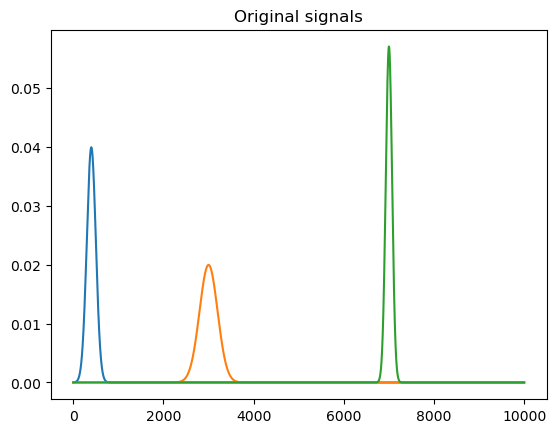

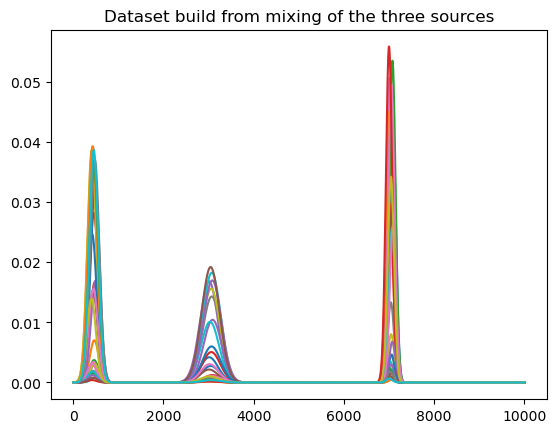

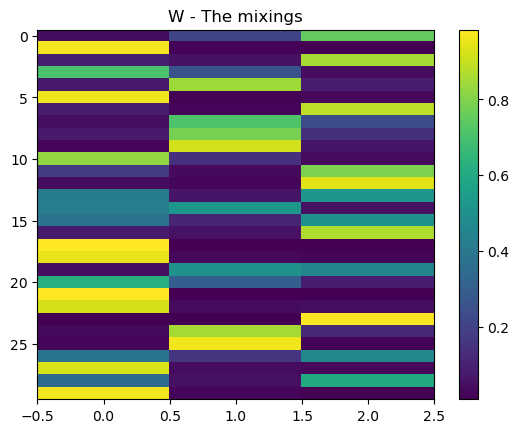

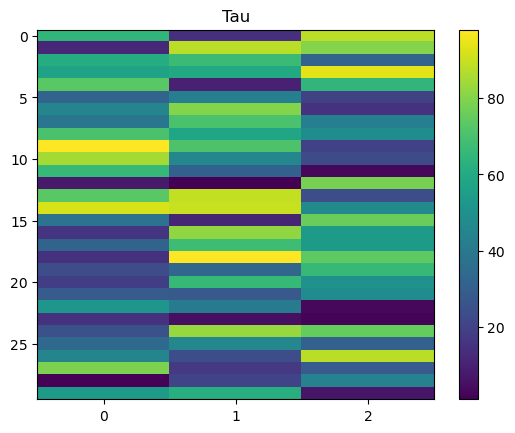

In [3]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 30, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V

# Random mixings:
W = np.random.dirichlet(np.ones(d)*0.5, N)*5
W = softmax(W, axis=1)
# Random gaussian shifts
tau = np.random.randint(0, 100, size=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [40, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)


plt.figure()
for signal in X:
    plt.plot(signal.real)
plt.title("Dataset build from mixing of the three sources")
plt.show()
plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
plt.title("W - The mixings")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

## Regular NMF

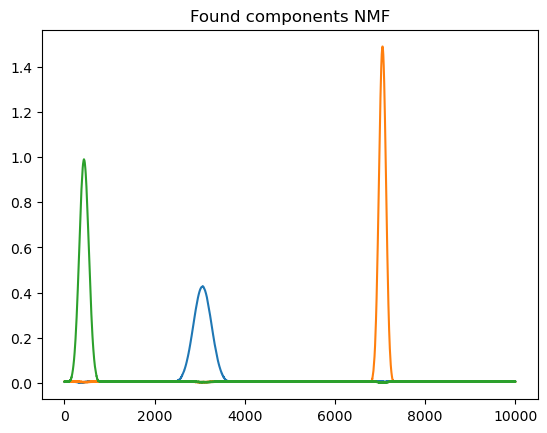

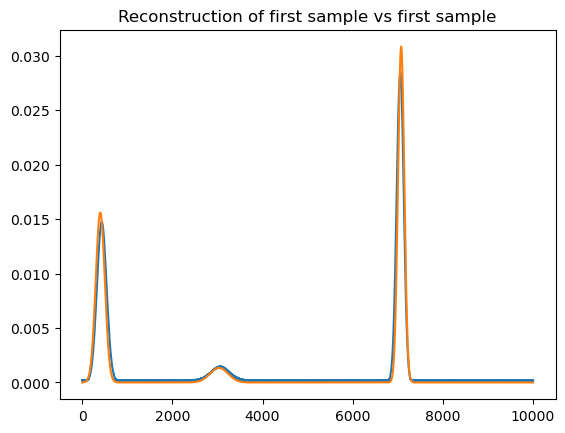

In [7]:

nmf = NMF(X, 3, lr=0.4, factor=0.5)
W, H = nmf.fit(verbose=True)
recon = np.matmul(W, H)

for signal in H:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

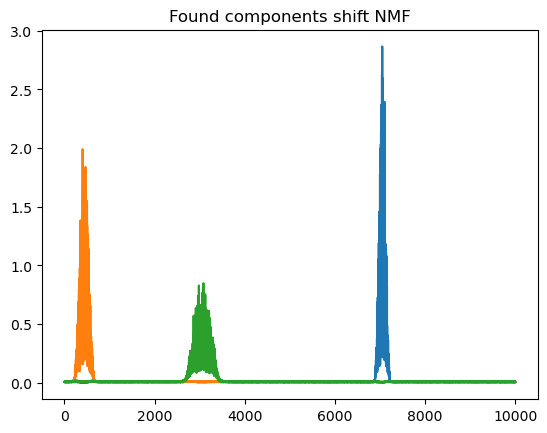

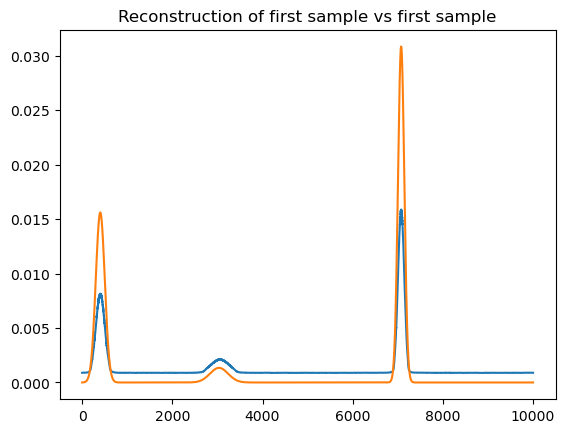

TypeError: Image data of dtype complex128 cannot be converted to float

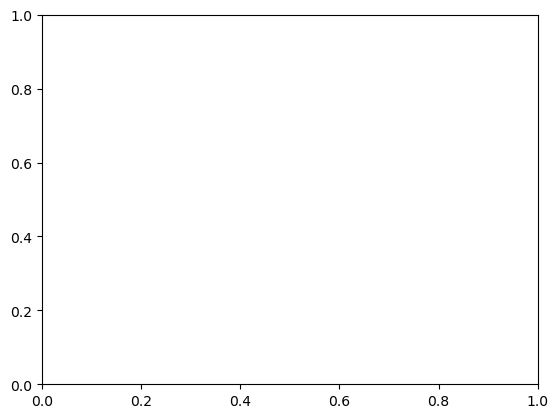

In [8]:

nmf = ShiftNMF(X, 3, lr=0.4, factor=0.5)
W, H, tau = nmf.fit(verbose=True)
recon = nmf.recon.detach().numpy()

for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

## Regular AA

c:\Users\Lenovo\OneDrive\Skrivebord\Fagprojekt\02466Fagprojekt2023\torchAA.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.C = torch.tensor(self.C, requires_grad=True)
c:\Users\Lenovo\OneDrive\Skrivebord\Fagprojekt\02466Fagprojekt2023\torchAA.py:40: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:276.)
  CX = torch.matmul(self.softmax(self.C).double(), self.X.double())


c:\Users\Lenovo\miniconda3\envs\fp\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


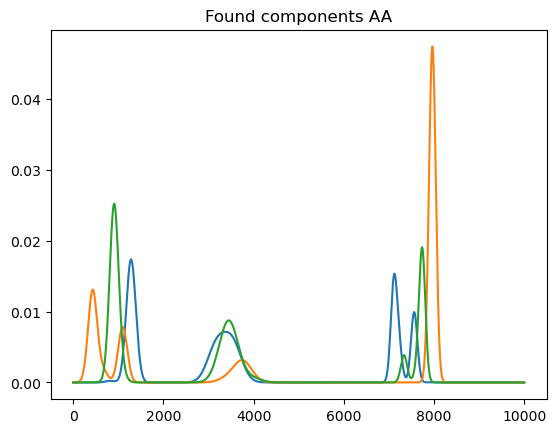

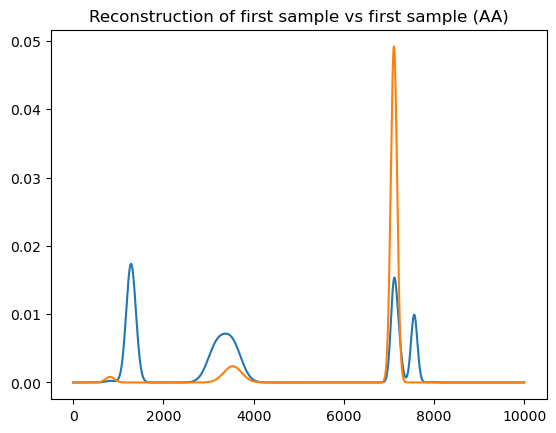

In [3]:
AA = torchAA(X, 3)
C, S = AA.fit(verbose=True)
CX = np.matmul(C, X)
recon = np.matmul(S, CX)

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

## Shift AA

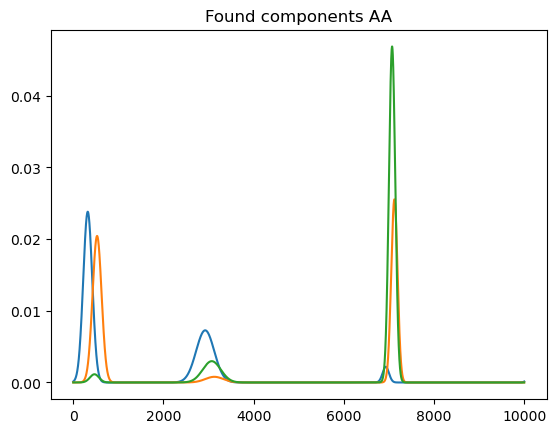

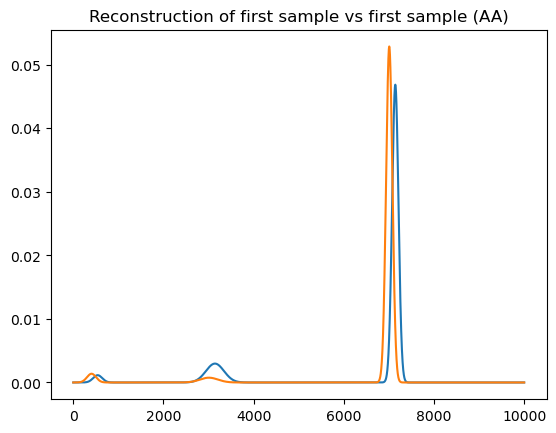

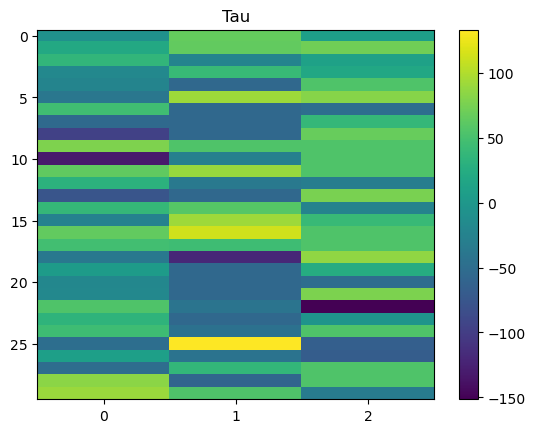

In [8]:
AA = torchShiftAA(X, 3)
C, S, tau = AA.fit(verbose=True)

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

CX = A
SCX = recon

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()